In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
import time

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.5.0
sys.version_info(major=3, minor=7, micro=11, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.19.5
pandas 1.1.5
sklearn 0.22.2.post1
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [1]:
!nvidia-smi

Tue Jul 27 08:28:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install kaggle

In [9]:
import json
token = {"username":"cskaoyan","key":"7755082acbfb31011b79c19e0b1b18ef"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [10]:
!cat /content/kaggle.json

{"username": "cskaoyan", "key": "7755082acbfb31011b79c19e0b1b18ef"}

In [11]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [12]:
!pwd

/content


In [ ]:
# !kaggle datasets download -d slothkong/10-monkey-species

 97% 531M/547M [00:03<00:00, 238MB/s]
100% 547M/547M [00:03<00:00, 155MB/s]


In [13]:
!kaggle competitions download -c cifar-10

 98% 103M/105M [00:02<00:00, 36.9MB/s] 
100% 105M/105M [00:02<00:00, 46.1MB/s]
  0% 0.00/575k [00:00<?, ?B/s]
100% 575k/575k [00:00<00:00, 79.6MB/s]
 99% 601M/610M [00:07<00:00, 102MB/s] 
100% 610M/610M [00:07<00:00, 80.1MB/s]
  0% 0.00/655k [00:00<?, ?B/s]
100% 655k/655k [00:00<00:00, 42.9MB/s]


In [14]:
!ls /content/competitions/cifar-10

sampleSubmission.csv.zip  test.7z  train.7z  trainLabels.csv


In [15]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./competitions/cifar-10/train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 2.2 MB 14.1 MB/s 
     |████████████████████████████████| 121 kB 52.8 MB/s 
     |████████████████████████████████| 357 kB 41.5 MB/s 
     |████████████████████████████████| 1.9 MB 35.6 MB/s 


In [16]:
!ls /content/competitions/cifar-10/train|wc -l

50000


In [ ]:
#测试集
a =py7zr.SevenZipFile(r'./competitions/cifar-10/test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [ ]:
!ls /content/competitions/cifar-10/test|wc -l

300000


In [ ]:
!unzip -o -d /content/competitions/cifar-10 ./competitions/cifar-10/sampleSubmission.csv.zip

Archive:  ./competitions/cifar-10/sampleSubmission.csv.zip
  inflating: /content/competitions/cifar-10/sampleSubmission.csv  


In [ ]:
#所有的类别
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

train_lables_file = 'competitions/cifar-10/trainLabels.csv'
test_csv_file = 'competitions/cifar-10/sampleSubmission.csv'
train_folder = 'competitions/cifar-10/train/'
test_folder = 'competitions/cifar-10/test'

def parse_csv_file(filepath, folder):
    """Parses csv files into (filename(path), label) format"""
    results = []
    #读取所有行
    with open(filepath, 'r') as f:
#         lines = f.readlines()  为什么加[1:]，可以试这个
        lines = f.readlines()[1:]
    for line in lines:
        image_id, label_str = line.strip('\n').split(',')
        image_full_path = os.path.join(folder, image_id + '.png')
        results.append((image_full_path, label_str))
    return results

#解析对应的文件夹
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)
#打印
import pprint
pprint.pprint(train_labels_info[0:5])
pprint.pprint(test_csv_info[0:5])
print(len(train_labels_info), len(test_csv_info))

[('competitions/cifar-10/train/1.png', 'frog'),
 ('competitions/cifar-10/train/2.png', 'truck'),
 ('competitions/cifar-10/train/3.png', 'truck'),
 ('competitions/cifar-10/train/4.png', 'deer'),
 ('competitions/cifar-10/train/5.png', 'automobile')]
[('competitions/cifar-10/test/1.png', 'cat'),
 ('competitions/cifar-10/test/2.png', 'cat'),
 ('competitions/cifar-10/test/3.png', 'cat'),
 ('competitions/cifar-10/test/4.png', 'cat'),
 ('competitions/cifar-10/test/5.png', 'cat')]
50000 300000


In [ ]:
# train_df = pd.DataFrame(train_labels_info)
train_df = pd.DataFrame(train_labels_info[0:45000])
valid_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)

train_df.columns = ['filepath', 'class']
valid_df.columns = ['filepath', 'class']
test_df.columns = ['filepath', 'class']

print(train_df.head())
print(valid_df.head())
print(test_df.head())

                            filepath       class
0  competitions/cifar-10/train/1.png        frog
1  competitions/cifar-10/train/2.png       truck
2  competitions/cifar-10/train/3.png       truck
3  competitions/cifar-10/train/4.png        deer
4  competitions/cifar-10/train/5.png  automobile
                                filepath       class
0  competitions/cifar-10/train/45001.png       horse
1  competitions/cifar-10/train/45002.png  automobile
2  competitions/cifar-10/train/45003.png        deer
3  competitions/cifar-10/train/45004.png  automobile
4  competitions/cifar-10/train/45005.png    airplane
                           filepath class
0  competitions/cifar-10/test/1.png   cat
1  competitions/cifar-10/test/2.png   cat
2  competitions/cifar-10/test/3.png   cat
3  competitions/cifar-10/test/4.png   cat
4  competitions/cifar-10/test/5.png   cat


In [ ]:
height = 32
width = 32
channels = 3
batch_size = 32
num_classes = 10

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    #讲labels转换为id
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = True,
    class_mode = 'sparse',
)

#和上面一致
valid_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")

train_num = train_generator.samples
valid_num = valid_generator.samples
print(train_num, valid_num)

Found 45000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.
45000 5000


In [ ]:
for i in range(2):
    x, y = train_generator.next()
    print(x.shape, y.shape)
    print(y)

(32, 32, 32, 3) (32,)
[2. 1. 4. 4. 4. 4. 6. 5. 2. 8. 4. 6. 6. 3. 7. 1. 7. 2. 8. 8. 3. 0. 5. 3.
 9. 1. 4. 5. 6. 7. 9. 2.]
(32, 32, 32, 3) (32,)
[0. 7. 2. 7. 5. 5. 7. 0. 5. 4. 9. 7. 6. 3. 0. 4. 4. 4. 6. 3. 5. 4. 6. 6.
 4. 1. 8. 2. 4. 4. 3. 0.]


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),#为了是模型训练的更快
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=3, padding='same',
                        activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 256)       1

In [ ]:
epochs = 20
history = model.fit_generator(train_generator,
                              steps_per_epoch = train_num // batch_size,
                              epochs = epochs,
                              validation_data = valid_generator,
                              validation_steps = valid_num // batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
1406/1406 [==============================] - 89s 39ms/step - loss: 2.4768 - accuracy: 0.2960 - val_loss: 1.8256 - val_accuracy: 0.4127
Epoch 2/20
1406/1406 [==============================] - 50s 35ms/step - loss: 1.4808 - accuracy: 0.4653 - val_loss: 1.4100 - val_accuracy: 0.5274
Epoch 3/20
1406/1406 [==============================] - 50s 35ms/step - loss: 1.2585 - accuracy: 0.5533 - val_loss: 1.4271 - val_accuracy: 0.5671
Epoch 4/20
1406/1406 [==============================] - 48s 34ms/step - loss: 1.0959 - accuracy: 0.6190 - val_loss: 0.9509 - val_accuracy: 0.6747
Epoch 5/20
1406/1406 [==============================] - 49s 35ms/step - loss: 0.9524 - accuracy: 0.6716 - val_loss: 0.8885 - val_accuracy: 0.7165
Epoch 6/20
1406/1406 [==============================] - 49s 35ms/step - loss: 0.8642 - accuracy: 0.7037 - val_loss: 1.0119 - val_accuracy: 0.7027
Epoch 7/20
1406/1406 [==============================] - 48s 34ms/step - loss: 0.8042 - accuracy: 0.7251 - val_loss: 0.7368 -

{'loss': [1.8540828227996826, 1.416763186454773, 1.213291049003601, 1.068687081336975, 0.9410074353218079, 0.852234959602356, 0.7878528833389282, 0.7165282368659973, 0.6755282282829285, 0.64002525806427, 0.6060716509819031, 0.5788384675979614, 0.5560576319694519, 0.53462153673172, 0.5110576748847961, 0.49622586369514465, 0.47375330328941345, 0.4681094288825989, 0.444454163312912, 0.43600010871887207], 'accuracy': [0.3599226176738739, 0.489881694316864, 0.571962296962738, 0.6262675523757935, 0.6756804585456848, 0.7087706923484802, 0.731431245803833, 0.7564935088157654, 0.7706813812255859, 0.7822229266166687, 0.7934086322784424, 0.8017034530639648, 0.8105319142341614, 0.8192047476768494, 0.825942873954773, 0.8318359851837158, 0.8383517265319824, 0.841620683670044, 0.8490926623344421, 0.8532512187957764], 'val_loss': [1.8256393671035767, 1.4100003242492676, 1.4271239042282104, 0.9509029984474182, 0.8884903192520142, 1.0119094848632812, 0.7368106842041016, 0.7203167676925659, 0.65010887384

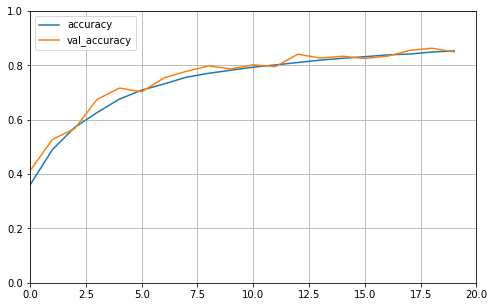

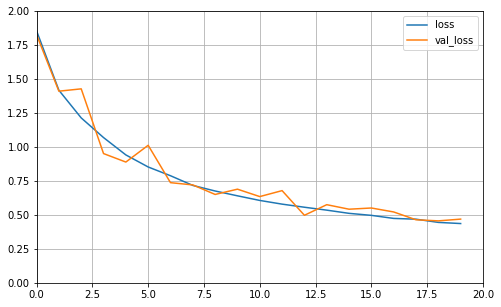

In [ ]:
print(history.history)
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    directory = './',
    x_col = 'filepath',
    y_col = 'class',
    classes = class_names,
    target_size = (height, width),
    batch_size = batch_size,
    seed = 7,
    shuffle = False,
    class_mode = "sparse")
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [ ]:
#这里运行时间太久，等上了GPU再说
test_predict = model.predict_generator(test_generator,
                                       workers = 3,
                                       use_multiprocessing = True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
print(test_predict.shape)

(300000, 10)


In [ ]:
print(test_predict[0:5])

[[2.4849296e-02 5.0397746e-02 1.2561632e-02 1.4841009e-02 5.7477966e-02
  8.9358306e-03 1.6829580e-02 8.6065112e-03 8.3252378e-03 7.9717517e-01]
 [9.9523634e-01 1.1593577e-04 2.3513830e-03 2.8329884e-04 4.4506174e-04
  2.2991333e-05 2.0133718e-04 5.9952887e-05 1.0730857e-03 2.1068346e-04]
 [1.1804236e-04 4.3381551e-01 6.4012465e-06 7.2206271e-06 2.0333023e-06
  2.7767894e-06 3.2136068e-05 3.4775935e-06 1.2567935e-05 5.6599987e-01]
 [3.9605456e-04 2.5288986e-05 9.5391215e-07 3.8302264e-07 9.9712440e-07
  1.8704438e-07 5.2466049e-07 1.7156383e-07 9.9953616e-01 3.9359162e-05]
 [9.9915433e-01 3.8812154e-06 4.5432715e-04 3.3686661e-05 1.1012247e-04
  2.6094824e-06 1.6186637e-05 1.9951398e-05 1.9850496e-04 6.4024243e-06]]


In [ ]:
test_predict_class_indices = np.argmax(test_predict, axis = 1)

In [ ]:
print(test_predict_class_indices[0:5])

[9 0 9 8 0]


In [ ]:
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [ ]:
print(test_predict_class[0:5])

['truck', 'airplane', 'truck', 'ship', 'airplane']


In [ ]:
#产生最终的报告
def generate_submissions(filename, predict_class):
  with open(filename, 'w') as f:
    f.write('id,label\n')
    for i in range(len(predict_class)):
      f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./submission.csv"
generate_submissions(output_file, test_predict_class)

In [ ]:
!ls

competitions  datasets	kaggle.json  sample_data  submission.csv


# 新段落

# 新段落

# 新段落